In [6]:
from google.colab import drive
drive.mount('/content/drive')
train_file = "/content/drive/MyDrive/group_proj/rnn/Data/Train/PCE.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


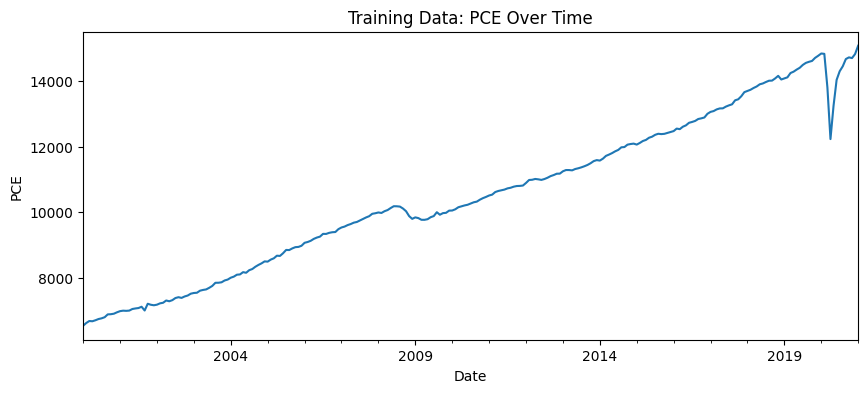

Training sequences: (241, 12), Training targets: (241,)
Testing sequences: (35, 12), Testing targets: (35,)


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# Define file paths for training and testing data
train_file = "/content/drive/MyDrive/group_proj/rnn/Data/Train/PCE.csv"
test_file  = "/content/drive/MyDrive/group_proj/rnn/Data/Test/PCE.csv"


# Load Training Data
train_df = pd.read_csv(train_file, parse_dates=['Date'])
train_df = train_df.rename(columns={'Value': 'PCE'})
train_df.set_index('Date', inplace=True)

# Load Testing Data
test_df = pd.read_csv(test_file, parse_dates=['Date'])
test_df = test_df.rename(columns={'Value': 'PCE'})
test_df.set_index('Date', inplace=True)

# Visualise the trend of the training data
plt.figure(figsize=(10, 4))
train_df['PCE'].plot(title='Training Data: PCE Over Time')
plt.xlabel('Date')
plt.ylabel('PCE')
plt.show()

# Fit the scaler on the training data and transform both train and test sets.
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['PCE']])
test_scaled = scaler.transform(test_df[['PCE']])

# Convert the scaled data to 1D arrays
train_series = train_scaled.flatten()
test_series  = test_scaled.flatten()

# Create Sequences from the Data
def create_sequences(data, seq_length):
    """
    Creates sequences of length `seq_length` as inputs and the subsequent value as the target.
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i : i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

# Set the sequence length
sequence_length = 12
X_train, y_train = create_sequences(train_series, sequence_length)
X_test, y_test   = create_sequences(test_series, sequence_length)

print(f"Training sequences: {X_train.shape}, Training targets: {y_train.shape}")
print(f"Testing sequences: {X_test.shape}, Testing targets: {y_test.shape}")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

1. Define the RNN Model

In [9]:
import torch
import torch.nn as nn

# Define computation device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # Define a fully connected layer for the final output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate through the RNN
        out, _ = self.rnn(x, h0)
        # Take the output from the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Initialize the RNN model
rnn_model = RNNModel().to(device)
print(rnn_model)


RNNModel(
  (rnn): RNN(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


2. Train the RNN Model

In [10]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
num_epochs = 50

for epoch in range(num_epochs):
    rnn_model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = rnn_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    # Evaluate on the test set
    rnn_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = rnn_model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")


Epoch 1/50 - Train Loss: 0.1467 - Test Loss: 1.0886
Epoch 2/50 - Train Loss: 0.0638 - Test Loss: 0.5236
Epoch 3/50 - Train Loss: 0.0542 - Test Loss: 0.5427
Epoch 4/50 - Train Loss: 0.0434 - Test Loss: 0.5392
Epoch 5/50 - Train Loss: 0.0338 - Test Loss: 0.3038
Epoch 6/50 - Train Loss: 0.0189 - Test Loss: 0.1415
Epoch 7/50 - Train Loss: 0.0036 - Test Loss: 0.0105
Epoch 8/50 - Train Loss: 0.0025 - Test Loss: 0.0608
Epoch 9/50 - Train Loss: 0.0022 - Test Loss: 0.0595
Epoch 10/50 - Train Loss: 0.0009 - Test Loss: 0.0218
Epoch 11/50 - Train Loss: 0.0009 - Test Loss: 0.0312
Epoch 12/50 - Train Loss: 0.0009 - Test Loss: 0.0387
Epoch 13/50 - Train Loss: 0.0008 - Test Loss: 0.0336
Epoch 14/50 - Train Loss: 0.0007 - Test Loss: 0.0386
Epoch 15/50 - Train Loss: 0.0007 - Test Loss: 0.0305
Epoch 16/50 - Train Loss: 0.0007 - Test Loss: 0.0276
Epoch 17/50 - Train Loss: 0.0007 - Test Loss: 0.0316
Epoch 18/50 - Train Loss: 0.0007 - Test Loss: 0.0323
Epoch 19/50 - Train Loss: 0.0007 - Test Loss: 0.0341
Ep

3. Make Predictions with the RNN Model

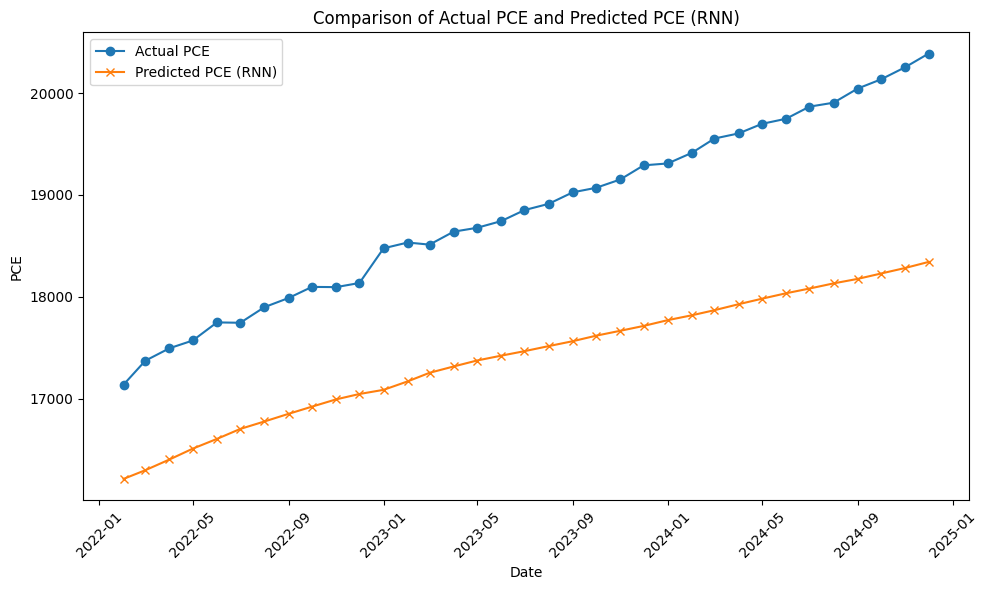

In [11]:
rnn_model.eval()
rnn_predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = rnn_model(inputs)
        rnn_predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# Concatenate batches into single arrays
rnn_predictions = np.concatenate(rnn_predictions)
actuals = np.concatenate(actuals)

# Inverse transform the normalised predictions and actual values back to the original scale
rnn_predictions_inv = scaler.inverse_transform(rnn_predictions)
actuals_inv = scaler.inverse_transform(actuals)

# Extract the dates corresponding to the test predictions.
test_dates = test_df.index[sequence_length:]

# Plot the actual vs. predicted PCE values for RNN
plt.figure(figsize=(10, 6))
plt.plot(test_dates, actuals_inv, label='Actual PCE', marker='o')
plt.plot(test_dates, rnn_predictions_inv, label='Predicted PCE (RNN)', marker='x')
plt.legend()
plt.title("Comparison of Actual PCE and Predicted PCE (RNN)")
plt.xlabel("Date")
plt.ylabel("PCE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


LSTM - Natalie's model

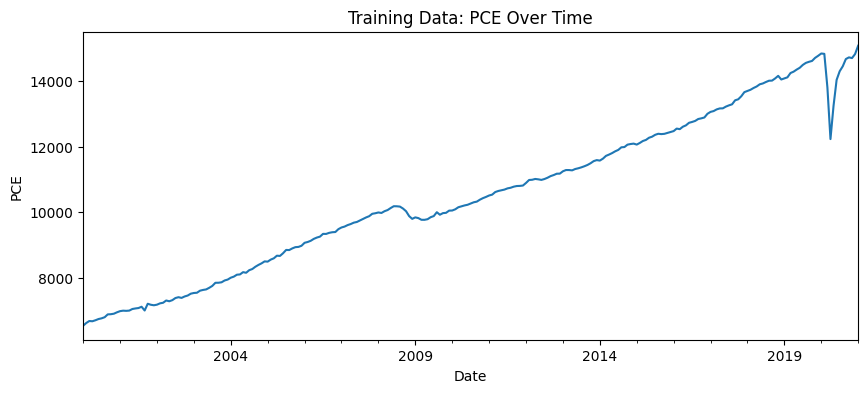

Training sequences: (241, 12), Training targets: (241,)
Testing sequences: (35, 12), Testing targets: (35,)
LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)
Epoch 1/50 - Train Loss: 0.2805 - Test Loss: 1.7005
Epoch 2/50 - Train Loss: 0.1705 - Test Loss: 1.2476
Epoch 3/50 - Train Loss: 0.0790 - Test Loss: 0.6475
Epoch 4/50 - Train Loss: 0.0598 - Test Loss: 0.4209
Epoch 5/50 - Train Loss: 0.0477 - Test Loss: 0.6041
Epoch 6/50 - Train Loss: 0.0420 - Test Loss: 0.5357
Epoch 7/50 - Train Loss: 0.0353 - Test Loss: 0.3176
Epoch 8/50 - Train Loss: 0.0287 - Test Loss: 0.2385
Epoch 9/50 - Train Loss: 0.0210 - Test Loss: 0.1623
Epoch 10/50 - Train Loss: 0.0128 - Test Loss: 0.0178
Epoch 11/50 - Train Loss: 0.0058 - Test Loss: 0.0025
Epoch 12/50 - Train Loss: 0.0030 - Test Loss: 0.0340
Epoch 13/50 - Train Loss: 0.0032 - Test Loss: 0.0243
Epoch 14/50 - Train Loss: 0.0027 - Test Loss: 0.0030
Epoch 15/50 - Train Loss: 0.0023 - Test Loss: 0.

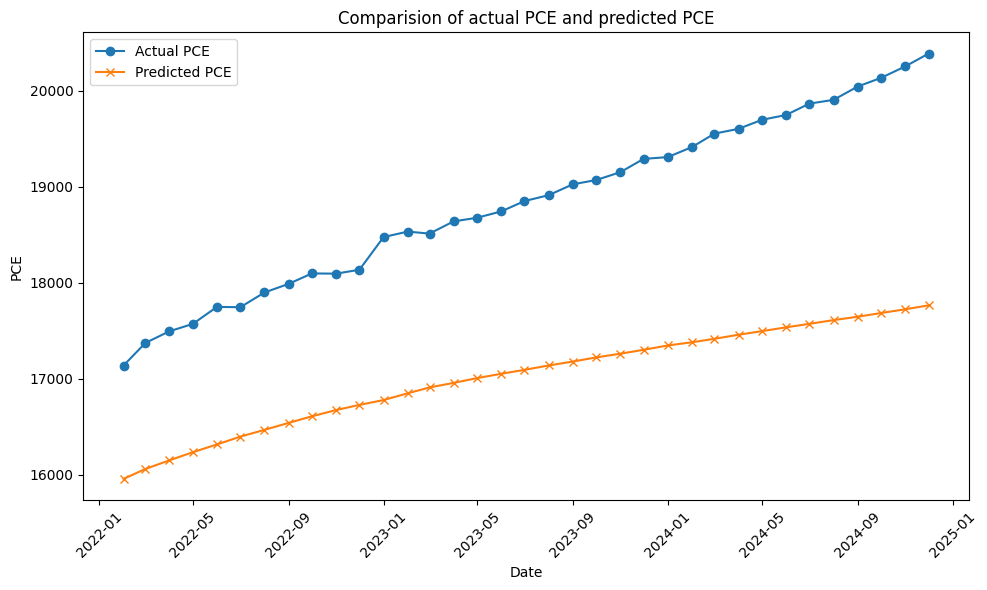

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# Define file paths for training and testing data
train_file = "/content/drive/MyDrive/group_proj/rnn/Data/Train/PCE.csv"
test_file  = "/content/drive/MyDrive/group_proj/rnn/Data/Test/PCE.csv"

# Load Training Data
train_df = pd.read_csv(train_file, parse_dates=['Date'])
train_df = train_df.rename(columns={'Value': 'PCE'})
train_df.set_index('Date', inplace=True)

# Load Testing Data
test_df = pd.read_csv(test_file, parse_dates=['Date'])
test_df = test_df.rename(columns={'Value': 'PCE'})
test_df.set_index('Date', inplace=True)

# Visualise the trend of the training data
plt.figure(figsize=(10, 4))
train_df['PCE'].plot(title='Training Data: PCE Over Time')
plt.xlabel('Date')
plt.ylabel('PCE')
plt.show()

# Fit the scaler on the training data and transform both train and test sets.
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['PCE']])
test_scaled = scaler.transform(test_df[['PCE']])

# Convert the scaled data to 1D arrays
train_series = train_scaled.flatten()
test_series  = test_scaled.flatten()

# Create Sequences from the Data
def create_sequences(data, seq_length):
    """
    Creates sequences of length `seq_length` as inputs and the subsequent value as the target.
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i : i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

# Set the sequence length
sequence_length = 12
X_train, y_train = create_sequences(train_series, sequence_length)
X_test, y_test   = create_sequences(test_series, sequence_length)

print(f"Training sequences: {X_train.shape}, Training targets: {y_train.shape}")
print(f"Testing sequences: {X_test.shape}, Testing targets: {y_test.shape}")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create the LSTM Model using Pytorch
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Define a fully connected layer for the final output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialise hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate through the LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Take the output from the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Set the computation device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")# GPU if available, otherwise use CPU
model = LSTMModel().to(device)
print(model)

# Model training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")

# Making predictions
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# Concatenate batches into single arrays
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverse transform the normalised predictions and actual values back to the original scale
predictions_inv = scaler.inverse_transform(predictions)
actuals_inv = scaler.inverse_transform(actuals)

# Extract the dates corresponding to the test predictions.
test_dates = test_df.index[sequence_length:]

# Plot the actual vs. predicted PCE values
plt.figure(figsize=(10, 6))
plt.plot(test_dates, actuals_inv, label='Actual PCE', marker='o')
plt.plot(test_dates, predictions_inv, label='Predicted PCE', marker='x')
plt.legend()
plt.title("Comparision of actual PCE and predicted PCE")
plt.xlabel("Date")
plt.ylabel("PCE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

4. Compare LSTM vs. RNN Performance

LSTM Model MSE: 3453161.2500
RNN Model MSE: 2126966.7500


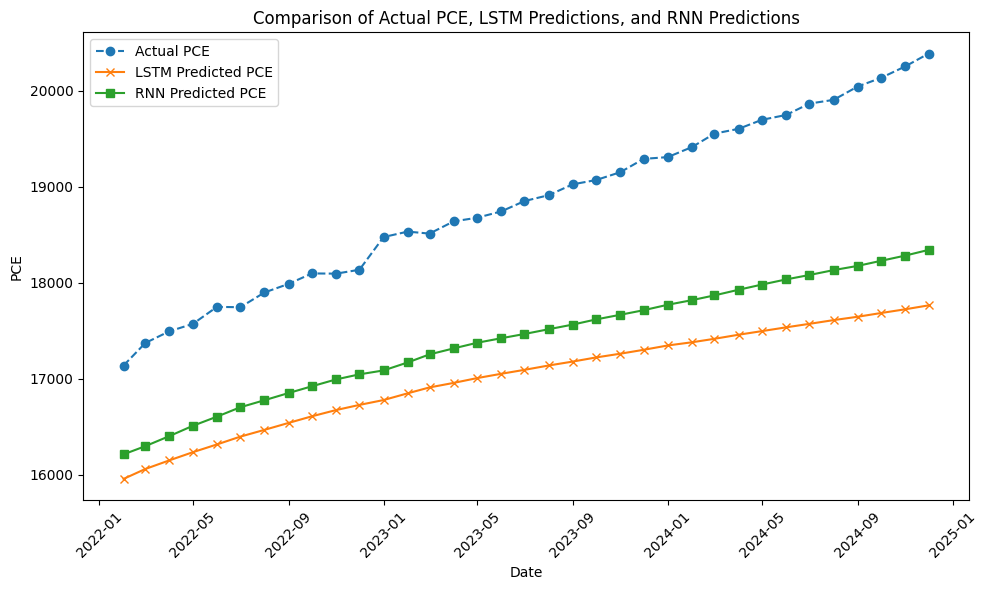

In [15]:
# Compute Mean Squared Error for comparison
from sklearn.metrics import mean_squared_error

lstm_mse = mean_squared_error(actuals_inv, predictions_inv)
rnn_mse = mean_squared_error(actuals_inv, rnn_predictions_inv)

print(f"LSTM Model MSE: {lstm_mse:.4f}")
print(f"RNN Model MSE: {rnn_mse:.4f}")

# Plot LSTM vs RNN predictions
plt.figure(figsize=(10, 6))
plt.plot(test_dates, actuals_inv, label="Actual PCE", marker="o", linestyle="dashed")
plt.plot(test_dates, predictions_inv, label="LSTM Predicted PCE", marker="x")
plt.plot(test_dates, rnn_predictions_inv, label="RNN Predicted PCE", marker="s")
plt.legend()
plt.title("Comparison of Actual PCE, LSTM Predictions, and RNN Predictions")
plt.xlabel("Date")
plt.ylabel("PCE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
